# Potential conflicts in transatlantic flights #

In [22]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [32]:
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import conflict
import analysis
import os
import networkx as nx
import tools

In [36]:
# read in all data
inputFile = '../data/TrajDataV2_20120729.txt'
trajectories = pd.read_csv('%s.csv' % inputFile, index_col='flightIndex')

rawPointConflicts = {}
pointConflicts = {}
parallelConflicts = {}
flights2Conflicts = {}
reducedPointConflicts = {}
reducedParallelConflicts = {}
multiConflicts = {}

mindistance = 30.0
mintimes = range(1,121)
delays = [1, 2, 3]
dthresholds = [1, 2, 3]
maxDepartDelays = [10, 20, 30]


for mintime in mintimes:
    name = "mindist%05.1f_mintime%03i" % (mindistance, mintime)
    
    rawPointConflictFile = '%s.%s.rawPointConflicts.csv' % (inputFile, name)
    if os.path.exists(rawPointConflictFile):
        rawPointConflicts[mintime] = pd.read_csv(rawPointConflictFile, index_col='conflictIndex')
   
    multiConflictFile = '%s.%s.multiConflicts.csv' % (inputFile, name)
    if os.path.exists(multiConflictFile):
        multiConflicts[mintime] = pd.read_csv(multiConflictFile, index_col='multiConflictIndex')
        
    pointConflictFile = '%s.%s.pointConflicts.csv' % (inputFile, name)
    if os.path.exists(pointConflictFile):
        pointConflicts[mintime] = pd.read_csv(pointConflictFile, index_col='conflictIndex')
        
    parallelConflictFile = '%s.%s.parallelConflicts.csv' % (inputFile, name)
    if os.path.exists(parallelConflictFile):
        parallelConflicts[mintime] = pd.read_csv(parallelConflictFile, index_col='parallelConflict')
        
    for delay in delays:
        for dthreshold in dthresholds:
            for maxDepartDelay in maxDepartDelays:
                flights2ConflictsFile = "%s.%s.flights2Conflicts_delay%03i_thres%03i_depart%03i.h5" % (inputFile, name, delay, dthreshold, maxDepartDelay)
                reducedPointConflictFile = "%s.%s.reducedPointConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delay, dthreshold, maxDepartDelay)
                reducedParallelConflictFile = "%s.%s.reducedParallelConflicts_delay%03i_thres%03i_depart%03i.csv" % (inputFile, name, delay, dthreshold, maxDepartDelay)
                key = (mintime, delay, dthreshold, maxDepartDelay)
                if os.path.exists(flights2ConflictsFile):
                    flights2Conflicts[key] = pd.read_hdf(flights2ConflictsFile, 'flights2Conflicts')
                if os.path.exists(reducedPointConflictFile):
                    reducedPointConflicts[key] = pd.read_csv(pointConflictFile, index_col='conflictIndex')
                if os.path.exists(reducedParallelConflictFile):
                    reducedParallelConflicts[key] = pd.read_csv(parallelConflictFile, index_col='parallelConflict')
        

In [19]:
%matplotlib inline

# Wind optimal trajectories #

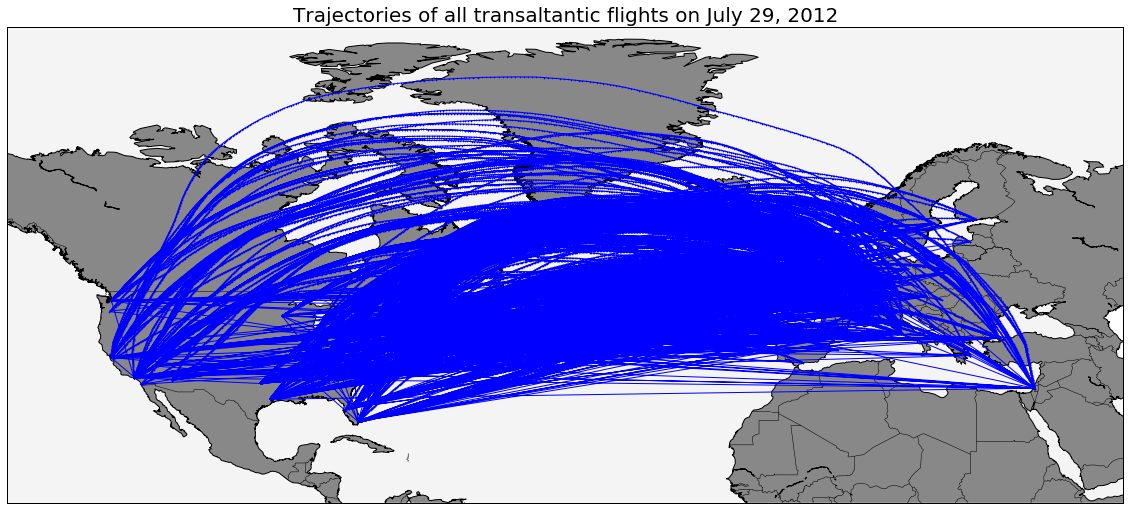

In [72]:
worldmap = analysis.prepareWorldMapPlot(llcrnrlon=-140, llcrnrlat=10, urcrnrlon=50, urcrnrlat=85)
analysis.addTrajectories(worldmap, trajectories)
plt.title('Trajectories of all transaltantic flights on July 29, 2012', fontsize=20);

# Pairwise Potential Conflicts #

- Spatial Conflict: Trajectory points to close to each other
- Real Conflict: Spatial conflict and arrival at the same time
- *Potential Conflict*: Spatial conflict which can become real

<img src="pics/potential_conflict.svg" width=800px />

# Spatial Conflict Detection #
Coarse grid algorithm (Olga Rodionova)

<img src="pics/spatial_conflict_detection_00.svg" width=800px />

# Spatial Conflict Detection #
Coarse grid algorithm (Olga Rodionova)

<img src="pics/spatial_conflict_detection_01.svg" width=800px />

# Spatial Conflict Detection #
Coarse grid algorithm (Olga Rodionova)

<img src="pics/spatial_conflict_detection_02.svg" width=800px />

# Spatial Conflict Detection #
Coarse grid algorithm (Olga Rodionova)

<img src="pics/spatial_conflict_detection_03.svg" width=800px />

# Spatial Conflict Detection #
Coarse grid algorithm (Olga Rodionova)

<img src="pics/spatial_conflict_detection_04.svg" width=800px />

# Spatial Conflict Detection #
Coarse grid algorithm (Olga Rodionova)

<img src="pics/spatial_conflict_detection_05.svg" width=800px />

# Spatial conflicts in wind optimal trajectories #

In [78]:
len(rawPointConflicts[60])

33878

Huge number of spatial conflicts: $N_\text{spatial} = 33878$

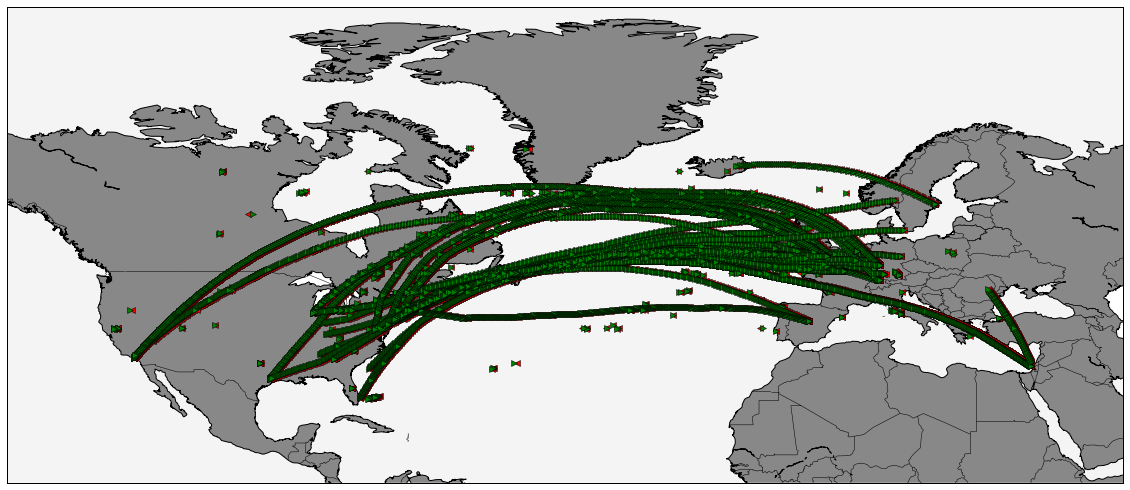

In [74]:
worldmap = analysis.prepareWorldMapPlot(llcrnrlon=-140, llcrnrlat=10, urcrnrlon=50, urcrnrlat=85)
analysis.addPointConflicts(worldmap, rawPointConflicts[60])

# Categorize spatial conflicts #

In [88]:
print "Number of point conflicts:", len(pointConflicts[60])
print "Number of parallel conflicts:", len(parallelConflicts[60].index.unique())
print "Reduction of", 100- 100 * (len(pointConflicts[60]) + len(parallelConflicts[60].index.unique()))/ len(rawPointConflicts[60]), "%"

Number of point conflicts: 2519
Number of parallel conflicts: 1649
Reduction of 88 %


Reduce the vast number of spatial conflicts by categorizing:
- Point Conflict: Isolated in time $N_\text{point} = 2519$
- Parallel conflict: Point conflicts consecutive in time $N_\text{parallel} = 1649$
- Reduction of $88 \%$

<img src="pics/spatial_conflict_categories.svg" width=800px />

# Potential conflict calculation #

Algorithm:
1. For each flight, order conflicts in time
2. For each spatial conflict, calculate the maximal delay of both flights
3. Remove spatial conflicts which can not become real conflicts
4. Repeat the above steps until convergence ($N_\text{spatial}$ invariant) 


<img src="pics/potential_conflict_detection.svg" width=600px />
Delays $d_i$ determine the arrival time $t$ at the conflict

# Subsets of the data #

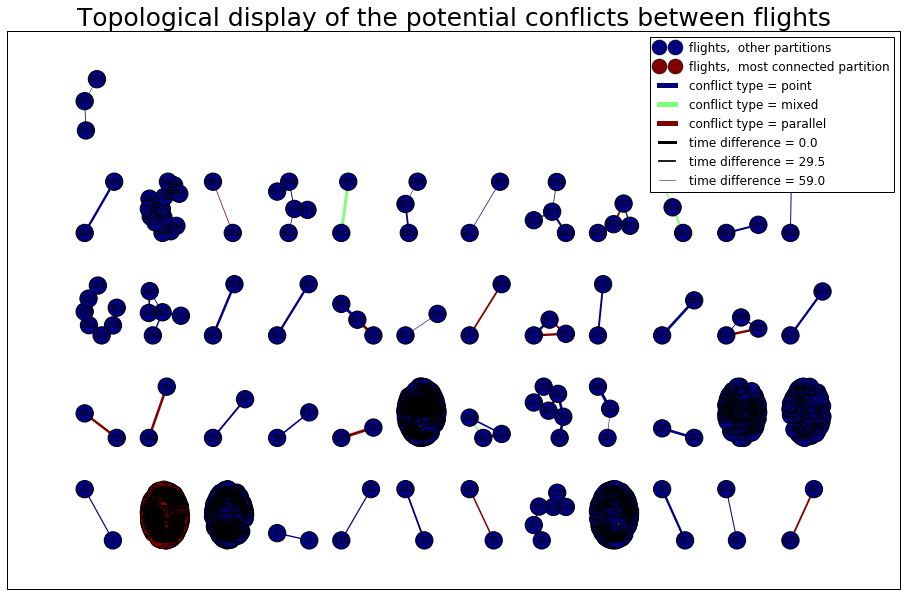

In [112]:
G = analysis.getConflictGraph(pointConflicts[60], parallelConflicts[60])
plt.figure(figsize=(16,10))
plt.xticks([])
plt.yticks([])
plt.title("Topological display of the potential conflicts between flights", fontsize=25)
analysis.plotGraph(G, connectedComponents=True)

# Subsets of the data #

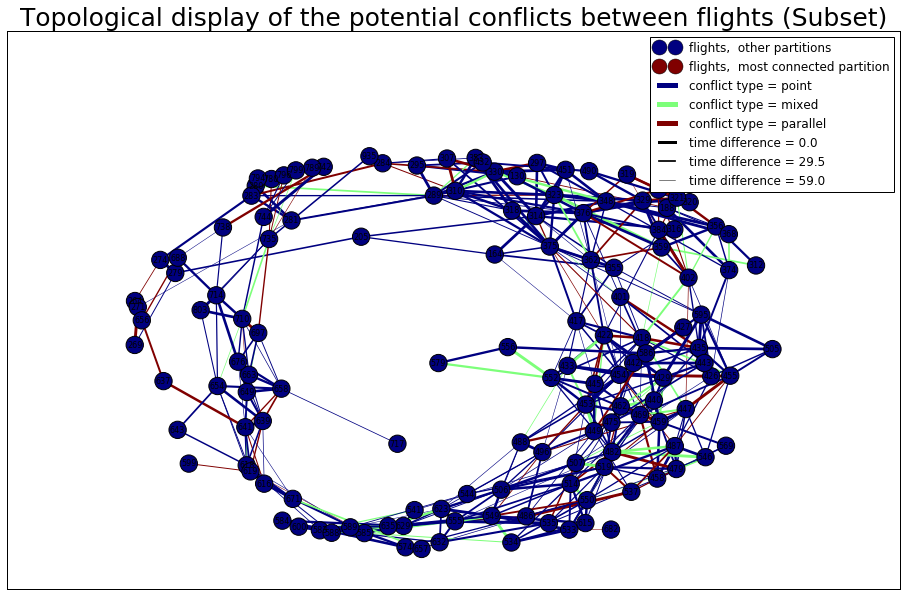

In [111]:
G = analysis.getConflictGraph(pointConflicts[60], parallelConflicts[60])
plt.figure(figsize=(16,10))
plt.xticks([])
plt.yticks([])
plt.ylim(1.4, 2.8)
plt.xlim(9.3, 10.7)
plt.title("Topological display of the potential conflicts between flights (Subset)", fontsize=25)
analysis.plotGraph(G, connectedComponents=True)

# Outlook #
- Disconnected subgraphs are natural subsets
- Try different subsets for Quantum Annealing
- Use subgraphs in hybrid approach